<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL/blob/master/FinRL_portfolio_allocation_NeurIPS_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [4]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /private/var/folders/55/9rwh4_kd0975rftnn8fyk6340000gn/T/pip-req-build-yu_ywsam
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /private/var/folders/55/9rwh4_kd0975rftnn8fyk6340000gn/T/pip-req-build-yu_ywsam
  Cloning https://github.com/quantopian/pyfolio.git to /private/var/folders/55/9rwh4_kd0975rftnn8fyk6340000gn/T/pip-install-nov4ojkn/pyfolio_cb4fb949f4d64541ad9141f6f6d64c5a
  Running command git clone -q https://github.com/quantopian/pyfolio.git /private/var/folders/55/9rwh4_kd0975rftnn8fyk6340000gn/T/pip-install-nov4ojkn/pyfolio_cb4fb949f4d64541ad9141f6f6d64c5a
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.neo_finrl.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
# from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts


import sys
sys.path.append("../FinRL-Library")

/opt/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a id='1.4'></a>
## 2.4. Create Folders

In [6]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [7]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [8]:
# !pip uninstall yfinance
# !pip uninstall pandas-datareader
# !pip install yfinance --upgrade --no-cache-dir
# !pip install pandas-datareader

In [9]:
from yahoo_fin.stock_info import *
df = get_data('AAPL', start_date = '2008-01-01',
                        end_date = '2021-07-01')
df

open        high         low       close    adjclose  \
2008-01-02    7.116786    7.152143    6.876786    6.958571    5.974743   
2008-01-03    6.978929    7.049643    6.881786    6.961786    5.977503   
2008-01-04    6.837500    6.892857    6.388929    6.430357    5.521210   
2008-01-07    6.473214    6.557143    6.079643    6.344286    5.447309   
2008-01-08    6.433571    6.516429    6.100000    6.116071    5.251360   
...                ...         ...         ...         ...         ...   
2021-06-24  134.449997  134.639999  132.929993  133.410004  133.210419   
2021-06-25  133.460007  133.889999  132.809998  133.110001  132.910873   
2021-06-28  133.410004  135.250000  133.350006  134.779999  134.578369   
2021-06-29  134.800003  136.490005  134.350006  136.330002  136.126053   
2021-06-30  136.169998  137.410004  135.869995  136.960007  136.755112   

                volume ticker  
2008-01-02  1079178800   AAPL  
2008-01-03   842066400   AAPL  
2008-01-04  1455832000   AAPL  
2008-01-07  2072193200   AAPL  
2008-01-08  1523816000   AAPL  
...                ...    ...  
2021-06-24    68711000   AAPL  
2021-06-25    70783700   AAPL  
2021-06-28    62111300   AAPL  
2021-06-29    64556100   AAPL  
2021-06-30    63261400   AAPL  

[3398 rows x 7 columns]

In [10]:
import pandas as pd

In [11]:
df_total = []
for i in config.DOW_30_TICKER:
    df = get_data(i, start_date = '2008-01-01',
                        end_date = '2021-07-01')
    df_total.append(df)
df = pd.concat(df_total)

In [12]:
df

open       high        low      close   adjclose      volume  \
2008-01-02   7.116786   7.152143   6.876786   6.958571   5.974743  1079178800   
2008-01-03   6.978929   7.049643   6.881786   6.961786   5.977503   842066400   
2008-01-04   6.837500   6.892857   6.388929   6.430357   5.521210  1455832000   
2008-01-07   6.473214   6.557143   6.079643   6.344286   5.447309  2072193200   
2008-01-08   6.433571   6.516429   6.100000   6.116071   5.251360  1523816000   
...               ...        ...        ...        ...        ...         ...   
2021-06-24  76.800003  77.290001  76.260002  76.400002  76.091316     3549600   
2021-06-25  76.839996  78.129997  76.330002  76.540001  76.230743     3460700   
2021-06-28  76.589996  77.169998  75.550003  77.120003  76.808403     2092300   
2021-06-29  77.669998  78.180000  76.860001  77.129997  76.818359     2165100   
2021-06-30  77.000000  77.580002  76.879997  77.410004  77.097237     1860600   

           ticker  
2008-01-02   AAPL  
2008-01-03   AAPL  
2008-01-04   AAPL  
2008-01-07   AAPL  
2008-01-08   AAPL  
...           ...  
2021-06-24     DD  
2021-06-25     DD  
2021-06-28     DD  
2021-06-29     DD  
2021-06-30     DD  

[101887 rows x 7 columns]

In [13]:
df['date'] = df.index
df = df.reset_index().drop(columns = 'index')
# use adjusted close price instead of close price
df["close"] = df["adjclose"]
# drop the adjusted close price column
df = df.drop(columns = 'adjclose')
df

open       high        low      close      volume ticker  \
0        7.116786   7.152143   6.876786   5.974743  1079178800   AAPL   
1        6.978929   7.049643   6.881786   5.977503   842066400   AAPL   
2        6.837500   6.892857   6.388929   5.521210  1455832000   AAPL   
3        6.473214   6.557143   6.079643   5.447309  2072193200   AAPL   
4        6.433571   6.516429   6.100000   5.251360  1523816000   AAPL   
...           ...        ...        ...        ...         ...    ...   
101882  76.800003  77.290001  76.260002  76.091316     3549600     DD   
101883  76.839996  78.129997  76.330002  76.230743     3460700     DD   
101884  76.589996  77.169998  75.550003  76.808403     2092300     DD   
101885  77.669998  78.180000  76.860001  76.818359     2165100     DD   
101886  77.000000  77.580002  76.879997  77.097237     1860600     DD   

             date  
0      2008-01-02  
1      2008-01-03  
2      2008-01-04  
3      2008-01-07  
4      2008-01-08  
...           ...  
101882 2021-06-24  
101883 2021-06-25  
101884 2021-06-28  
101885 2021-06-29  
101886 2021-06-30  

[101887 rows x 7 columns]

In [14]:
df = df.rename(columns={'ticker': 'tic'})
df["day"] = df["date"].dt.dayofweek
df

open       high        low      close      volume   tic  \
0        7.116786   7.152143   6.876786   5.974743  1079178800  AAPL   
1        6.978929   7.049643   6.881786   5.977503   842066400  AAPL   
2        6.837500   6.892857   6.388929   5.521210  1455832000  AAPL   
3        6.473214   6.557143   6.079643   5.447309  2072193200  AAPL   
4        6.433571   6.516429   6.100000   5.251360  1523816000  AAPL   
...           ...        ...        ...        ...         ...   ...   
101882  76.800003  77.290001  76.260002  76.091316     3549600    DD   
101883  76.839996  78.129997  76.330002  76.230743     3460700    DD   
101884  76.589996  77.169998  75.550003  76.808403     2092300    DD   
101885  77.669998  78.180000  76.860001  76.818359     2165100    DD   
101886  77.000000  77.580002  76.879997  77.097237     1860600    DD   

             date  day  
0      2008-01-02    2  
1      2008-01-03    3  
2      2008-01-04    4  
3      2008-01-07    0  
4      2008-01-08    1  
...           ...  ...  
101882 2021-06-24    3  
101883 2021-06-25    4  
101884 2021-06-28    0  
101885 2021-06-29    1  
101886 2021-06-30    2  

[101887 rows x 8 columns]

In [15]:
# df = YahooDownloader(start_date = '2008-01-01',
#                      end_date = '2021-07-01',
#                      ticker_list = config.DOW_30_TICKER).fetch_data()  

In [17]:
df.head()    

open      high       low     close      volume   tic       date  day
0  7.116786  7.152143  6.876786  5.974743  1079178800  AAPL 2008-01-02    2
1  6.978929  7.049643  6.881786  5.977503   842066400  AAPL 2008-01-03    3
2  6.837500  6.892857  6.388929  5.521210  1455832000  AAPL 2008-01-04    4
3  6.473214  6.557143  6.079643  5.447309  2072193200  AAPL 2008-01-07    0
4  6.433571  6.516429  6.100000  5.251360  1523816000  AAPL 2008-01-08    1

In [18]:
df.shape

(101887, 8)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [19]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [20]:
df.shape

(98542, 12)

In [21]:
df.head()

open       high        low      close      volume   tic  \
0       7.116786   7.152143   6.876786   5.974743  1079178800  AAPL   
3398   52.090000  52.320000  50.790001  40.795723     8053700   AXP   
6796   87.570000  87.839996  86.000000  63.481632     4303000    BA   
10194  72.559998  72.669998  70.050003  47.896084     6337800   CAT   
13592  27.000000  27.299999  26.209999  19.569740    64338900  CSCO   

            date  day  macd  rsi_30     cci_30  dx_30  
0     2008-01-02    2   0.0   100.0 -66.666667  100.0  
3398  2008-01-02    2   0.0   100.0 -66.666667  100.0  
6796  2008-01-02    2   0.0   100.0 -66.666667  100.0  
10194 2008-01-02    2   0.0   100.0 -66.666667  100.0  
13592 2008-01-02    2   0.0   100.0 -66.666667  100.0

In [22]:
df = df[['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd', 'rsi_30','cci_30', 'dx_30']]
df.head()

date       open       high        low      close      volume  \
0     2008-01-02   7.116786   7.152143   6.876786   5.974743  1079178800   
3398  2008-01-02  52.090000  52.320000  50.790001  40.795723     8053700   
6796  2008-01-02  87.570000  87.839996  86.000000  63.481632     4303000   
10194 2008-01-02  72.559998  72.669998  70.050003  47.896084     6337800   
13592 2008-01-02  27.000000  27.299999  26.209999  19.569740    64338900   

        tic  day  macd  rsi_30     cci_30  dx_30  
0      AAPL    2   0.0   100.0 -66.666667  100.0  
3398    AXP    2   0.0   100.0 -66.666667  100.0  
6796     BA    2   0.0   100.0 -66.666667  100.0  
10194   CAT    2   0.0   100.0 -66.666667  100.0  
13592  CSCO    2   0.0   100.0 -66.666667  100.0

In [23]:
df.head()   # their code 

date       open       high        low      close      volume  \
0     2008-01-02   7.116786   7.152143   6.876786   5.974743  1079178800   
3398  2008-01-02  52.090000  52.320000  50.790001  40.795723     8053700   
6796  2008-01-02  87.570000  87.839996  86.000000  63.481632     4303000   
10194 2008-01-02  72.559998  72.669998  70.050003  47.896084     6337800   
13592 2008-01-02  27.000000  27.299999  26.209999  19.569740    64338900   

        tic  day  macd  rsi_30     cci_30  dx_30  
0      AAPL    2   0.0   100.0 -66.666667  100.0  
3398    AXP    2   0.0   100.0 -66.666667  100.0  
6796     BA    2   0.0   100.0 -66.666667  100.0  
10194   CAT    2   0.0   100.0 -66.666667  100.0  
13592  CSCO    2   0.0   100.0 -66.666667  100.0

## Add covariance matrix as states

In [24]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
        

In [25]:
df.shape

(91234, 14)

In [26]:
df.head()

date       open       high        low      close     volume   tic  \
0 2008-12-31   3.070357   3.133571   3.047857   2.617247  607541200  AAPL   
1 2008-12-31  17.969999  18.750000  17.910000  15.025569    9625600   AXP   
2 2008-12-31  41.590000  43.049999  41.500000  32.005901    5443100    BA   
3 2008-12-31  43.700001  45.099998  43.700001  31.095800    6277400   CAT   
4 2008-12-31  16.180000  16.549999  16.120001  12.019092   37513700  CSCO   

   day      macd     rsi_30      cci_30      dx_30  \
0    2 -0.083669  42.254778  -80.491633  16.129793   
1    2 -0.964124  42.554845  -75.362550  25.776759   
2    2 -0.279798  47.440267  156.995097   5.366299   
3    2  0.688541  51.205314   98.432308  26.331746   
4    2 -0.102729  45.961924   11.978197  13.387087   

                                            cov_list  \
0  [[0.0013489688855373024, 0.000990979372521563,...   
1  [[0.0013489688855373024, 0.000990979372521563,...   
2  [[0.0013489688855373024, 0.000990979372521563,...   
3  [[0.0013489688855373024, 0.000990979372521563,...   
4  [[0.0013489688855373024, 0.000990979372521563,...   

                                         return_list  
0  tic             AAPL       AXP        BA      ...  
1  tic             AAPL       AXP        BA      ...  
2  tic             AAPL       AXP        BA      ...  
3  tic             AAPL       AXP        BA      ...  
4  tic             AAPL       AXP        BA      ...

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31

In [27]:
train = data_split(df, '2009-01-01','2020-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [28]:
train.head()

date       open       high        low      close     volume   tic  \
0 2009-01-02   3.067143   3.251429   3.041429   2.782837  746015200  AAPL   
0 2009-01-02  18.570000  19.520000  18.400000  15.657365   10955700   AXP   
0 2009-01-02  42.799999  45.560001  42.779999  33.941101    7010200    BA   
0 2009-01-02  44.910000  46.980000  44.709999  32.655109    7117200   CAT   
0 2009-01-02  16.410000  17.000000  16.250000  12.505757   40980600  CSCO   

   day      macd     rsi_30      cci_30      dx_30  \
0    4 -0.071058  45.440192  -32.083886   2.140064   
0    4 -0.857433  43.957537  -42.753090  16.335101   
0    4 -0.002007  50.822042  272.812831  20.494464   
0    4  0.875031  53.661249  129.760396  34.637448   
0    4 -0.061562  48.322168   54.454064   2.653808   

                                            cov_list  \
0  [[0.001366150477084819, 0.0010028349094392064,...   
0  [[0.001366150477084819, 0.0010028349094392064,...   
0  [[0.001366150477084819, 0.0010028349094392064,...   
0  [[0.001366150477084819, 0.0010028349094392064,...   
0  [[0.001366150477084819, 0.0010028349094392064,...   

                                         return_list  
0  tic             AAPL       AXP        BA      ...  
0  tic             AAPL       AXP        BA      ...  
0  tic             AAPL       AXP        BA      ...  
0  tic             AAPL       AXP        BA      ...  
0  tic             AAPL       AXP        BA      ...

## Environment for Portfolio Allocation


In [29]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [30]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 29


In [31]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [32]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [33]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv
#from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df, 
                stock_dim,
                hmax,                
                initial_amount,
                buy_cost_pct,
                sell_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                risk_indicator_col='turbulence',
                make_plots = False, 
                print_verbosity = 10,
                day = 0, 
                initial=True,
                previous_state=[],
                model_name = '',
                mode='',
                iteration=''):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,)) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space,))
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name=model_name
        self.mode=mode 
        self.iteration=iteration
        # initalize state
        self.state = self._initiate_state()
        
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self._get_date()]
        #self.reset()
        self._seed()
        


    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index+1]>0: 
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index+self.stock_dim+1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(abs(action),self.state[index+self.stock_dim+1])
                    sell_amount = self.state[index+1] * sell_num_shares * (1- self.sell_cost_pct)
                    #update balance
                    self.state[0] += sell_amount

                    self.state[index+self.stock_dim+1] -= sell_num_shares
                    self.cost +=self.state[index+1] * sell_num_shares * self.sell_cost_pct
                    self.trades+=1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares
            
        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence>=self.turbulence_threshold:
                if self.state[index+1]>0: 
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions 
                    if self.state[index+self.stock_dim+1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index+self.stock_dim+1]
                        sell_amount = self.state[index+1]*sell_num_shares* (1- self.sell_cost_pct)
                        #update balance
                        self.state[0] += sell_amount
                        self.state[index+self.stock_dim+1] =0
                        self.cost += self.state[index+1]*sell_num_shares* \
                                    self.sell_cost_pct
                        self.trades+=1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    
    def _buy_stock(self, index, action):

        def _do_buy():
            if self.state[index+1]>0: 
                #Buy only if the price is > 0 (no missing data in this particular date)       
                available_amount = self.state[0] // self.state[index+1]
                # print('available_amount:{}'.format(available_amount))
                
                #update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = self.state[index+1] * buy_num_shares * (1+ self.buy_cost_pct)
                self.state[0] -= buy_amount

                self.state[index+self.stock_dim+1] += buy_num_shares
                
                self.cost+=self.state[index+1] * buy_num_shares * self.buy_cost_pct
                self.trades+=1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence< self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory,'r')
        plt.savefig('results/account_value_trade_{}.png'.format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()            
            end_total_asset = self.state[0]+ \
                sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))- self.initial_amount 
            df_total_value.columns = ['account_value']
            df_total_value['date'] = self.date_memory
            df_total_value['daily_return']=df_total_value['account_value'].pct_change(1)
            if df_total_value['daily_return'].std() !=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ['account_rewards']
            df_rewards['date'] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value['daily_return'].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name!='') and (self.mode!=''):
                df_actions = self.save_action_memory()
                df_actions.to_csv('results/actions_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration))
                df_total_value.to_csv('results/account_value_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration),index=False)
                df_rewards.to_csv('results/account_rewards_{}_{}_{}.csv'.format(self.mode,self.model_name, self.iteration),index=False)
                plt.plot(self.asset_memory,'r')
                plt.savefig('results/account_value_{}_{}_{}.png'.format(self.mode,self.model_name, self.iteration),index=False)
                plt.close()

            # Add outputs to logger interface
            #logger.record("environment/portfolio_value", end_total_asset)
            #logger.record("environment/total_reward", tot_reward)
            #logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            #logger.record("environment/total_cost", self.cost)
            #logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax #actions initially is scaled between 0 to 1
            actions = (actions.astype(int)) #convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence>=self.turbulence_threshold:
                    actions=np.array([-self.hmax]*self.stock_dim)
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)
            
            #state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day,:]    
            if self.turbulence_threshold is not None:     
                self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state =  self._update_state()
                           
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset            
            self.rewards_memory.append(self.reward)
            self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        #initiate state
        self.state = self._initiate_state()
        
        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self._get_date()]
        
        self.episode+=1

        return self.state
    
    def render(self, mode='human',close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique())>1:
                # for multiple stock
                state = [self.initial_amount] + \
                         self.data.close.values.tolist() + \
                         [0]*self.stock_dim  + \
                         sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])
            else:
                # for single stock
                state = [self.initial_amount] + \
                        [self.data.close] + \
                        [0]*self.stock_dim  + \
                        sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        else:
            #Using Previous State
            if len(self.df.tic.unique())>1:
                # for multiple stock
                state = [self.previous_state[0]] + \
                         self.data.close.values.tolist() + \
                         self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]  + \
                         sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])
            else:
                # for single stock
                state = [self.previous_state[0]] + \
                        [self.data.close] + \
                        self.previous_state[(self.stock_dim+1):(self.stock_dim*2+1)]  + \
                        sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        return state

    def _update_state(self):
        if len(self.df.tic.unique())>1:
            # for multiple stock
            state =  [self.state[0]] + \
                      self.data.close.values.tolist() + \
                      list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                      sum([self.data[tech].values.tolist() for tech in self.tech_indicator_list ], [])

        else:
            # for single stock
            state =  [self.state[0]] + \
                     [self.data.close] + \
                     list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                     sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
                          
        return state

    def _get_date(self):
        if len(self.df.tic.unique())>1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'account_value':asset_list})
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique())>1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ['date']
            
            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs


In [34]:
# common library
import pandas as pd
import numpy as np
import time
import gym

from finrl.apps import config
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split

# from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
# RL models from stable-baselines

from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3.td3.policies import MlpPolicy
from stable_baselines3.common.noise import (
    NormalActionNoise,
    OrnsteinUhlenbeckActionNoise,
)
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import (
    NormalActionNoise,
    OrnsteinUhlenbeckActionNoise,
)
from stable_baselines3 import SAC


MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
}


class DRLAgent:
    """Provides implementations for DRL algorithms

    Attributes
    ----------
        env: gym environment class
            user-defined class

    Methods
    -------
        train_PPO()
            the implementation for PPO algorithm
        train_A2C()
            the implementation for A2C algorithm
        train_DDPG()
            the implementation for DDPG algorithm
        train_TD3()
            the implementation for TD3 algorithm
        train_SAC()
            the implementation for SAC algorithm
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    @staticmethod
    def DRL_prediction(model, environment):
        test_env, test_obs = environment.get_sb_env()
        """make a prediction"""
        account_memory = []
        actions_memory = []
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs)
            #account_memory = test_env.env_method(method_name="save_asset_memory")
            #actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
              account_memory = test_env.env_method(method_name="save_asset_memory")
              actions_memory = test_env.env_method(method_name="save_action_memory")
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(model_kwargs)
        model = MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            **model_kwargs,
        )
        return model

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps, tb_log_name=tb_log_name)
        return model


class DRLEnsembleAgent:
    @staticmethod
    def get_model(model_name,
                    env,
                    policy="MlpPolicy",
                    policy_kwargs=None,
                    model_kwargs=None,
                    verbose=1):

        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            temp_model_kwargs = MODEL_KWARGS[model_name]
        else:
            temp_model_kwargs = model_kwargs.copy()

        if "action_noise" in temp_model_kwargs:
            n_actions = env.action_space.shape[-1]
            temp_model_kwargs["action_noise"] = NOISE[temp_model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(temp_model_kwargs)
        model = MODELS[model_name](
            policy=policy,
            env=env,
            tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            **temp_model_kwargs,
        )
        return model

    @staticmethod
    def train_model(model, model_name, tb_log_name, iter_num, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps, tb_log_name=tb_log_name)
        model.save(f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{total_timesteps//1000}k_{iter_num}")
        return model

    @staticmethod
    def get_validation_sharpe(iteration,model_name):
        ###Calculate Sharpe ratio based on validation results###
        df_total_value = pd.read_csv('results/account_value_validation_{}_{}.csv'.format(model_name,iteration))
        sharpe = (4 ** 0.5) * df_total_value['daily_return'].mean() / \
                 df_total_value['daily_return'].std()
        return sharpe

    def __init__(self,df,
                train_period,val_test_period,
                rebalance_window, validation_window,
                stock_dim,
                hmax,                
                initial_amount,
                buy_cost_pct,
                sell_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                print_verbosity):

        self.df=df
        self.train_period = train_period
        self.val_test_period = val_test_period

        self.unique_trade_date = df[(df.date > val_test_period[0])&(df.date <= val_test_period[1])].date.unique()
        self.rebalance_window = rebalance_window
        self.validation_window = validation_window

        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.print_verbosity = print_verbosity


    def DRL_validation(self, model, test_data, test_env, test_obs):
        ###validation process###
        for i in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)

    def DRL_prediction(self,model,name,last_state,iter_num,turbulence_threshold,initial):
        ### make a prediction based on trained model###

        ## trading env
        trade_data = data_split(self.df, start=self.unique_trade_date[iter_num - self.rebalance_window], end=self.unique_trade_date[iter_num])
        trade_env = DummyVecEnv([lambda: StockTradingEnv(trade_data,
                                                        self.stock_dim,
                                                        self.hmax,
                                                        self.initial_amount,
                                                        self.buy_cost_pct,
                                                        self.sell_cost_pct,
                                                        self.reward_scaling,
                                                        self.state_space,
                                                        self.action_space,
                                                        self.tech_indicator_list,
                                                        turbulence_threshold=turbulence_threshold,
                                                        initial=initial,
                                                        previous_state=last_state,
                                                        model_name=name,
                                                        mode='trade',
                                                        iteration=iter_num,
                                                        print_verbosity=self.print_verbosity)])

        trade_obs = trade_env.reset()

        for i in range(len(trade_data.index.unique())):
            action, _states = model.predict(trade_obs)
            trade_obs, rewards, dones, info = trade_env.step(action)
            if i == (len(trade_data.index.unique()) - 2):
                # print(env_test.render())
                last_state = trade_env.render()

        df_last_state = pd.DataFrame({'last_state': last_state})
        df_last_state.to_csv('results/last_state_{}_{}.csv'.format(name, i), index=False)
        return last_state

    def run_ensemble_strategy(self,A2C_model_kwargs,PPO_model_kwargs,DDPG_model_kwargs,timesteps_dict):
        """Ensemble Strategy that combines PPO, A2C and DDPG"""
        print("============Start Ensemble Strategy============")
        # for ensemble model, it's necessary to feed the last state
        # of the previous model to the current model as the initial state
        last_state_ensemble = []

        ppo_sharpe_list = []
        ddpg_sharpe_list = []
        a2c_sharpe_list = []

        model_use = []
        validation_start_date_list = []
        validation_end_date_list = []
        iteration_list = []

        insample_turbulence = self.df[(self.df.date<self.train_period[1]) & (self.df.date>=self.train_period[0])]
        insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, .90)

        start = time.time()
        for i in range(self.rebalance_window + self.validation_window, len(self.unique_trade_date), self.rebalance_window):
            validation_start_date = self.unique_trade_date[i - self.rebalance_window - self.validation_window]
            validation_end_date = self.unique_trade_date[i - self.rebalance_window]

            validation_start_date_list.append(validation_start_date)
            validation_end_date_list.append(validation_end_date)
            iteration_list.append(i)

            print("============================================")
            ## initial state is empty
            if i - self.rebalance_window - self.validation_window == 0:
                # inital state
                initial = True
            else:
                # previous state
                initial = False

            # Tuning trubulence index based on historical data
            # Turbulence lookback window is one quarter (63 days)
            end_date_index = self.df.index[self.df["date"] == self.unique_trade_date[i - self.rebalance_window - self.validation_window]].to_list()[-1]
            start_date_index = end_date_index - 63 + 1

            historical_turbulence = self.df.iloc[start_date_index:(end_date_index + 1), :]

            historical_turbulence = historical_turbulence.drop_duplicates(subset=['date'])

            historical_turbulence_mean = np.mean(historical_turbulence.turbulence.values)

            #print(historical_turbulence_mean)

            if historical_turbulence_mean > insample_turbulence_threshold:
                # if the mean of the historical data is greater than the 90% quantile of insample turbulence data
                # then we assume that the current market is volatile,
                # therefore we set the 90% quantile of insample turbulence data as the turbulence threshold
                # meaning the current turbulence can't exceed the 90% quantile of insample turbulence data
                turbulence_threshold = insample_turbulence_threshold
            else:
                # if the mean of the historical data is less than the 90% quantile of insample turbulence data
                # then we tune up the turbulence_threshold, meaning we lower the risk
                turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 1)
                
            turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 0.99) 
            print("turbulence_threshold: ", turbulence_threshold)

            ############## Environment Setup starts ##############
            ## training env
            train = data_split(self.df, start=self.train_period[0], end=self.unique_trade_date[i - self.rebalance_window - self.validation_window])
            self.train_env = DummyVecEnv([lambda: StockTradingEnv(train,
                                                                self.stock_dim,
                                                                self.hmax,
                                                                self.initial_amount,
                                                                self.buy_cost_pct,
                                                                self.sell_cost_pct,
                                                                self.reward_scaling,
                                                                self.state_space,
                                                                self.action_space,
                                                                self.tech_indicator_list,
                                                                print_verbosity=self.print_verbosity)])

            validation = data_split(self.df, start=self.unique_trade_date[i - self.rebalance_window - self.validation_window],
                                    end=self.unique_trade_date[i - self.rebalance_window])
            ############## Environment Setup ends ##############

            ############## Training and Validation starts ##############
            print("======Model training from: ", self.train_period[0], "to ",
                  self.unique_trade_date[i - self.rebalance_window - self.validation_window])
            # print("training: ",len(data_split(df, start=20090000, end=test.datadate.unique()[i-rebalance_window]) ))
            # print("==============Model Training===========")
            print("======A2C Training========")
            model_a2c = self.get_model("a2c",self.train_env,policy="MlpPolicy",model_kwargs=A2C_model_kwargs)
            model_a2c = self.train_model(model_a2c, "a2c", tb_log_name="a2c_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['a2c']) #100_000

            print("======A2C Validation from: ", validation_start_date, "to ",validation_end_date)
            val_env_a2c = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                                self.stock_dim,
                                                                self.hmax,
                                                                self.initial_amount,
                                                                self.buy_cost_pct,
                                                                self.sell_cost_pct,
                                                                self.reward_scaling,
                                                                self.state_space,
                                                                self.action_space,
                                                                self.tech_indicator_list,
                                                                turbulence_threshold=turbulence_threshold,
                                                                iteration=i,
                                                                model_name='A2C',
                                                                mode='validation',
                                                                print_verbosity=self.print_verbosity)])
            val_obs_a2c = val_env_a2c.reset()
            self.DRL_validation(model=model_a2c,test_data=validation,test_env=val_env_a2c,test_obs=val_obs_a2c)
            sharpe_a2c = self.get_validation_sharpe(i,model_name="A2C")
            print("A2C Sharpe Ratio: ", sharpe_a2c)

            print("======PPO Training========")
            model_ppo = self.get_model("ppo",self.train_env,policy="MlpPolicy",model_kwargs=PPO_model_kwargs)
            model_ppo = self.train_model(model_ppo, "ppo", tb_log_name="ppo_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ppo']) #100_000
            print("======PPO Validation from: ", validation_start_date, "to ",validation_end_date)
            val_env_ppo = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                                self.stock_dim,
                                                                self.hmax,
                                                                self.initial_amount,
                                                                self.buy_cost_pct,
                                                                self.sell_cost_pct,
                                                                self.reward_scaling,
                                                                self.state_space,
                                                                self.action_space,
                                                                self.tech_indicator_list,
                                                                turbulence_threshold=turbulence_threshold,
                                                                iteration=i,
                                                                model_name='PPO',
                                                                mode='validation',
                                                                print_verbosity=self.print_verbosity)])
            val_obs_ppo = val_env_ppo.reset()
            self.DRL_validation(model=model_ppo,test_data=validation,test_env=val_env_ppo,test_obs=val_obs_ppo)
            sharpe_ppo = self.get_validation_sharpe(i,model_name="PPO")
            print("PPO Sharpe Ratio: ", sharpe_ppo)

            print("======DDPG Training========")
            model_ddpg = self.get_model("ddpg",self.train_env,policy="MlpPolicy",model_kwargs=DDPG_model_kwargs)
            model_ddpg = self.train_model(model_ddpg, "ddpg", tb_log_name="ddpg_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ddpg'])  #50_000
            print("======DDPG Validation from: ", validation_start_date, "to ",validation_end_date)
            val_env_ddpg = DummyVecEnv([lambda: StockTradingEnv(validation,
                                                                self.stock_dim,
                                                                self.hmax,
                                                                self.initial_amount,
                                                                self.buy_cost_pct,
                                                                self.sell_cost_pct,
                                                                self.reward_scaling,
                                                                self.state_space,
                                                                self.action_space,
                                                                self.tech_indicator_list,
                                                                turbulence_threshold=turbulence_threshold,
                                                                iteration=i,
                                                                model_name='DDPG',
                                                                mode='validation',
                                                                print_verbosity=self.print_verbosity)])
            val_obs_ddpg = val_env_ddpg.reset()
            self.DRL_validation(model=model_ddpg,test_data=validation,test_env=val_env_ddpg,test_obs=val_obs_ddpg)
            sharpe_ddpg = self.get_validation_sharpe(i,model_name="DDPG")

            ppo_sharpe_list.append(sharpe_ppo)
            a2c_sharpe_list.append(sharpe_a2c)
            ddpg_sharpe_list.append(sharpe_ddpg)

            print("======Best Model Retraining from: ", self.train_period[0], "to ",
                  self.unique_trade_date[i - self.rebalance_window])
            # Environment setup for model retraining up to first trade date
            #train_full = data_split(self.df, start=self.train_period[0], end=self.unique_trade_date[i - self.rebalance_window])
            #self.train_full_env = DummyVecEnv([lambda: StockTradingEnv(train_full,
            #                                                    self.stock_dim,
            #                                                    self.hmax,
            #                                                    self.initial_amount,
            #                                                    self.buy_cost_pct,
            #                                                    self.sell_cost_pct,
            #                                                    self.reward_scaling,
            #                                                    self.state_space,
            #                                                    self.action_space,
            #                                                    self.tech_indicator_list,
            #                                                    print_verbosity=self.print_verbosity)])
            # Model Selection based on sharpe ratio
            if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg):
                model_use.append('PPO')
                model_ensemble = model_ppo

                #model_ensemble = self.get_model("ppo",self.train_full_env,policy="MlpPolicy",model_kwargs=PPO_model_kwargs)
                #model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ppo']) #100_000
            elif (sharpe_a2c > sharpe_ppo) & (sharpe_a2c > sharpe_ddpg):
                model_use.append('A2C')
                model_ensemble = model_a2c

                #model_ensemble = self.get_model("a2c",self.train_full_env,policy="MlpPolicy",model_kwargs=A2C_model_kwargs)
                #model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['a2c']) #100_000
            else:
                model_use.append('DDPG')
                model_ensemble = model_ddpg

                #model_ensemble = self.get_model("ddpg",self.train_full_env,policy="MlpPolicy",model_kwargs=DDPG_model_kwargs)
                #model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ddpg']) #50_000

            ############## Training and Validation ends ##############

            ############## Trading starts ##############
            print("======Trading from: ", self.unique_trade_date[i - self.rebalance_window], "to ", self.unique_trade_date[i])
            #print("Used Model: ", model_ensemble)
            last_state_ensemble = self.DRL_prediction(model=model_ensemble, name="ensemble",
                                                     last_state=last_state_ensemble, iter_num=i,
                                                     turbulence_threshold = turbulence_threshold,
                                                     initial=initial)
            ############## Trading ends ##############

        end = time.time()
        print("Ensemble Strategy took: ", (end - start) / 60, " minutes")

        df_summary = pd.DataFrame([iteration_list,validation_start_date_list,validation_end_date_list,model_use,a2c_sharpe_list,ppo_sharpe_list,ddpg_sharpe_list]).T
        df_summary.columns = ['Iter','Val Start','Val End','Model Used','A2C Sharpe','PPO Sharpe','DDPG Sharpe']

        return df_summary






In [35]:
# from finrl.drl_agents.stablebaselines3.models import DRLAgent

In [36]:
# initialize
agent = DRLAgent(env = env_train)


### Model 1: **A2C**


In [37]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [38]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

Logging to tensorboard_log/a2c/a2c_2
-------------------------------------
| time/                 |           |
|    fps                | 101       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 2.03e+08  |
|    std                | 0.997     |
|    value_loss         | 2.57e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 169      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -41.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates         

### Model 2: **PPO**


In [115]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [116]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

Logging to tensorboard_log/ppo/ppo_1
-----------------------------
| time/              |      |
|    fps             | 650  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
begin_total_asset:1000000
end_total_asset:4847801.26117283
Sharpe:  0.8392229350853923
---------------------------------------
| time/                   |           |
|    fps                  | 586       |
|    iterations           | 2         |
|    time_elapsed         | 6         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.1     |
|    explained_variance   | -1.19e-07 |
|    learning_rate        | 0.0001    |
|    loss                 | 8.13e+14  |
|    n_updates            | 10        |
|    policy_gradient_loss | -6.13e-07 |
|    std                  

### Model 3: **DDPG**


In [66]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [67]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_2
begin_total_asset:1000000
end_total_asset:5517350.852111231
Sharpe:  0.9040061139571733
begin_total_asset:1000000
end_total_asset:5842975.202229903
Sharpe:  0.9321003182527587
begin_total_asset:1000000
end_total_asset:5842975.202229903
Sharpe:  0.9321003182527587
begin_total_asset:1000000
end_total_asset:5842975.202229903
Sharpe:  0.9321003182527587
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 41        |
|    time_elapsed    | 275       |
|    total timesteps | 11572     |
| train/             |           |
|    actor_loss      | -9.44e+07 |
|    critic_loss     | 1.32e+13  |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
----------------------------------
begin_total_asset:1000000
end_total_asset:5842975.202229903
Sharpe:  0.9321003182527587
begin_total_asset:1000000
end_total_asset:5842975.202229903
Sharpe:  0.9321003182527587
begin_total_a

### Model 4: **SAC**


In [119]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

Logging to tensorboard_log/sac/sac_1
begin_total_asset:1000000
end_total_asset:4742878.527267045
Sharpe:  0.8284567575666894
begin_total_asset:1000000
end_total_asset:4676491.080187851
Sharpe:  0.8185315058298828
begin_total_asset:1000000
end_total_asset:4676506.840561069
Sharpe:  0.8185330300147667
begin_total_asset:1000000
end_total_asset:4676485.228731914
Sharpe:  0.818531151553917
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 2         |
|    time_elapsed    | 5570      |
|    total timesteps | 11572     |
| train/             |           |
|    actor_loss      | -1.07e+08 |
|    critic_loss     | 9.19e+12  |
|    ent_coef        | 3.49      |
|    ent_coef_loss   | -299      |
|    learning_rate   | 0.0003    |
|    n_updates       | 11471     |
----------------------------------
begin_total_asset:1000000
end_total_asset:4676498.010425561
Sharpe:  0.8185327466189173
begin_total_asset:1000000
end_tota

### Model 5: **TD3**


In [2]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

NameError: name 'DRLAgent' is not defined

In [3]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

NameError: name 'agent' is not defined

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

In [39]:
trade = data_split(df,'2020-07-01', '2021-07-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [40]:
trade.shape

(7308, 14)

In [68]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1372955.7676721376
Sharpe:  2.1769467858520106
hit end!


In [42]:
df_daily_return.head()

date  daily_return
0 2020-07-01      0.000000
1 2020-07-02      0.006145
2 2020-07-06      0.015221
3 2020-07-07     -0.016507
4 2020-07-08      0.003473

In [43]:
df_daily_return.to_csv('df_daily_return.csv')

In [44]:
df_actions.head()

AAPL       AXP        BA       CAT      CSCO       CVX  \
date                                                                     
2020-07-01  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2020-07-02  0.022684  0.030267  0.023287  0.061661  0.022684  0.027191   
2020-07-06  0.020065  0.049533  0.025259  0.020065  0.023261  0.020065   
2020-07-07  0.022286  0.060581  0.029797  0.060581  0.054896  0.022286   
2020-07-08  0.056691  0.047740  0.022188  0.033361  0.020855  0.056691   

                  DD       DIS        GS        HD  ...       NKE       PFE  \
date                                                ...                       
2020-07-01  0.034483  0.034483  0.034483  0.034483  ...  0.034483  0.034483   
2020-07-02  0.022684  0.025547  0.061293  0.022684  ...  0.032045  0.028881   
2020-07-06  0.020065  0.020065  0.020065  0.020065  ...  0.020065  0.054541   
2020-07-07  0.022286  0.023817  0.022286  0.037891  ...  0.022286  0.022286   
2020-07-08  0.020855  0.020855  0.021548  0.056691  ...  0.020855  0.056691   

                  PG       RTX       TRV       UNH        VZ       WBA  \
date                                                                     
2020-07-01  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2020-07-02  0.022684  0.026434  0.061661  0.022684  0.022684  0.036455   
2020-07-06  0.035295  0.054541  0.025653  0.020065  0.038582  0.054541   
2020-07-07  0.022286  0.022286  0.038715  0.022286  0.040784  0.060581   
2020-07-08  0.054990  0.020855  0.020855  0.020855  0.029380  0.027241   

                 WMT       XOM  
date                            
2020-07-01  0.034483  0.034483  
2020-07-02  0.022684  0.056263  
2020-07-06  0.038634  0.024378  
2020-07-07  0.022286  0.022286  
2020-07-08  0.020855  0.041601  

[5 rows x 29 columns]

In [45]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [69]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [70]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.372956
Cumulative returns     0.372956
Annual volatility      0.150903
Sharpe ratio           2.176947
Calmar ratio           4.074094
Stability              0.940067
Max drawdown          -0.091543
Omega ratio            1.435469
Sortino ratio          3.354667
Skew                  -0.191831
Kurtosis               1.178817
Tail ratio             1.167355
Daily value at risk   -0.017708
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [71]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.334042
Cumulative returns     0.332517
Annual volatility      0.146033
Sharpe ratio           2.055458
Calmar ratio           3.740347
Stability              0.945402
Max drawdown          -0.089308
Omega ratio            1.408111
Sortino ratio          3.075978
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.078766
Daily value at risk   -0.017207
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (252, 8)


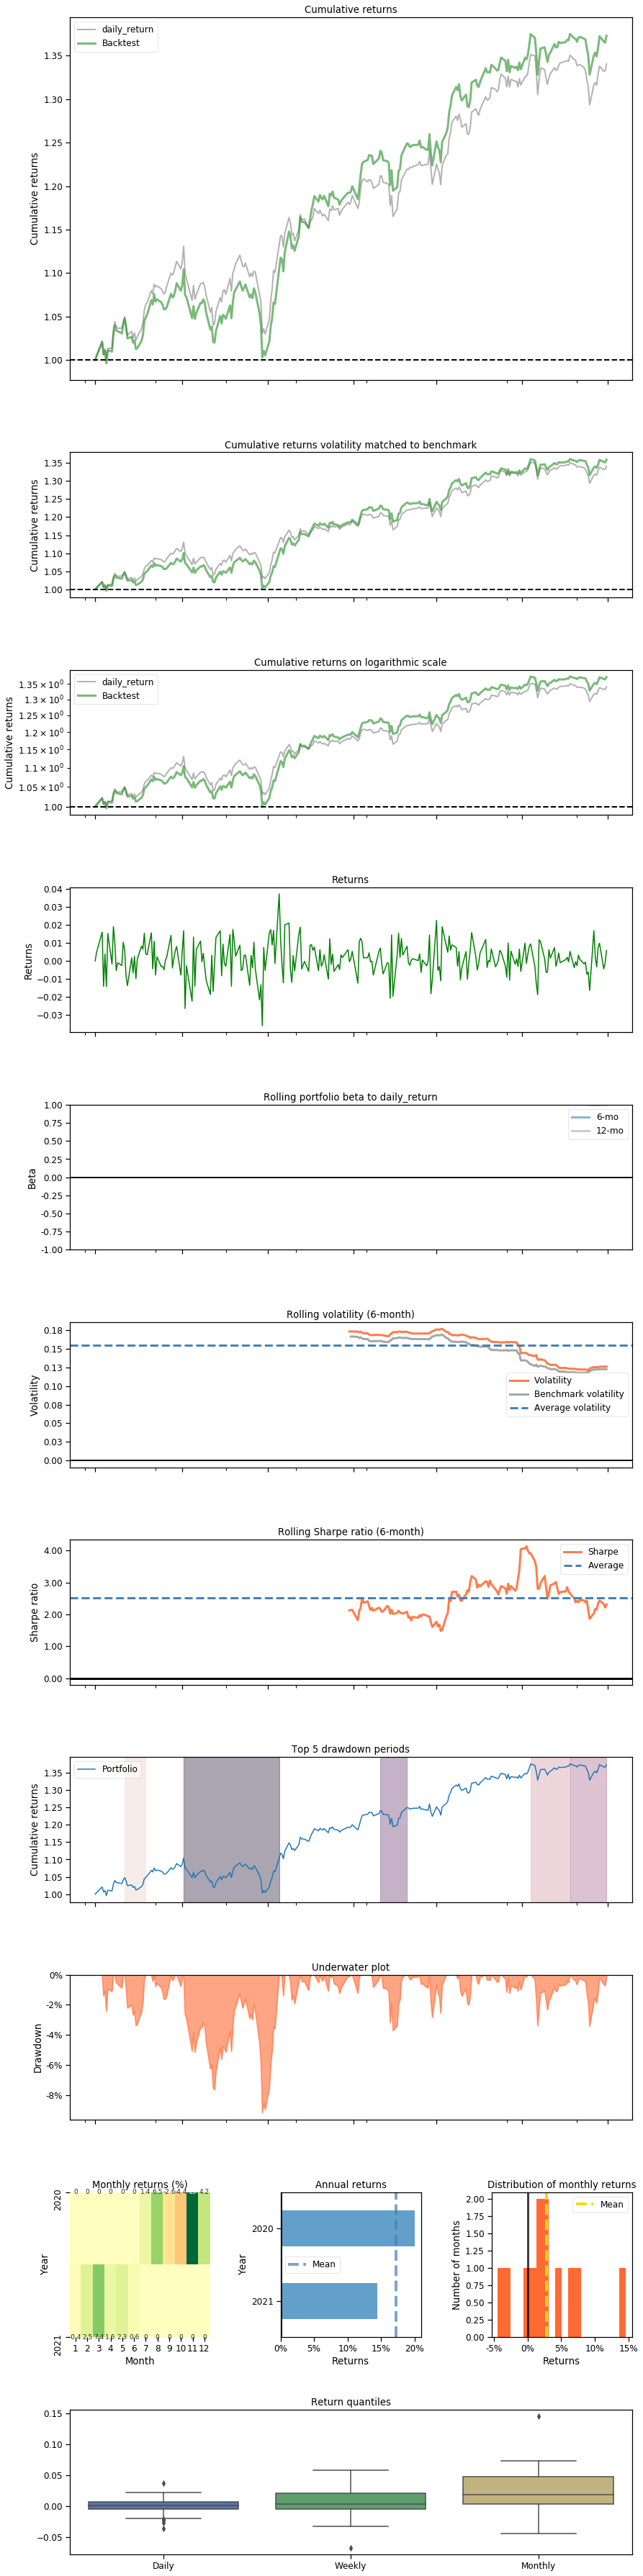

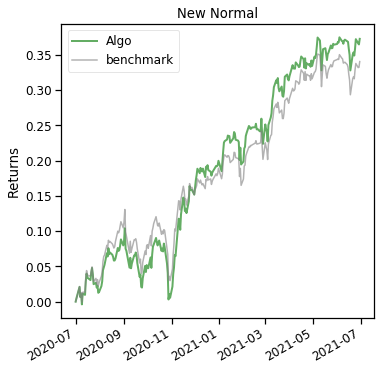

In [72]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-07-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

## Min-Variance Portfolio Allocation

In [50]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 60 kB 6.2 MB/s eta 0:00:011
     |████████████████████████████████| 869 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 164 kB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 10.6 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 126 kB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 4.9 MB/s eta 0:00:011
  Created wheel for ecos: filename=ecos-2.0.7.post1-cp37-cp37m-macosx_10_9_x86_64.whl size=72399 sha256=ed6a5d0710c6aa0b40a81d87173cdec9eaace382fb04c44715ddc06cb3b6b273
  Stored in directory: /Users/jialiangchen/Library/Caches/pip/wheels/70/e7/fd/4a4f957fc18a0f0407ca4b331c51e6a469c92efec58f732edf
  Created wheel for scs: filename=scs-2.1.4-cp37-cp37m-macosx_10_9_x86_64.whl size=124379 sha256=0e6e8941344209ff0dfffadaa5b8dbf39801e8b567760009d653e30aeaa04f43
  S

In [51]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [52]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [53]:
df.head()

date       open       high        low      close     volume   tic  \
0 2008-12-31   3.070357   3.133571   3.047857   2.617247  607541200  AAPL   
1 2008-12-31  17.969999  18.750000  17.910000  15.025569    9625600   AXP   
2 2008-12-31  41.590000  43.049999  41.500000  32.005901    5443100    BA   
3 2008-12-31  43.700001  45.099998  43.700001  31.095800    6277400   CAT   
4 2008-12-31  16.180000  16.549999  16.120001  12.019092   37513700  CSCO   

   day      macd     rsi_30      cci_30      dx_30  \
0    2 -0.083669  42.254778  -80.491633  16.129793   
1    2 -0.964124  42.554845  -75.362550  25.776759   
2    2 -0.279798  47.440267  156.995097   5.366299   
3    2  0.688541  51.205314   98.432308  26.331746   
4    2 -0.102729  45.961924   11.978197  13.387087   

                                            cov_list  \
0  [[0.0013489688855373024, 0.000990979372521563,...   
1  [[0.0013489688855373024, 0.000990979372521563,...   
2  [[0.0013489688855373024, 0.000990979372521563,...   
3  [[0.0013489688855373024, 0.000990979372521563,...   
4  [[0.0013489688855373024, 0.000990979372521563,...   

                                         return_list  
0  tic             AAPL       AXP        BA      ...  
1  tic             AAPL       AXP        BA      ...  
2  tic             AAPL       AXP        BA      ...  
3  tic             AAPL       AXP        BA      ...  
4  tic             AAPL       AXP        BA      ...

In [54]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

In [55]:
portfolio.head()

account_value
2020-07-01         1000000
2020-07-02  1006660.603811
2020-07-06  1016783.816387
2020-07-07  1015117.648878
2020-07-08  1013186.785163

In [56]:
a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1

In [57]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

In [58]:
dji_cumpod =(baseline_returns+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [61]:
!pip install plotly

     |████████████████████████████████| 21.8 MB 37.4 MB/s eta 0:00:01
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [62]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [63]:
time_ind = pd.Series(df_daily_return.date)

In [64]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [65]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()